# Predicting sentiment from product reviews


The goal of this first notebook is to explore logistic regression and feature engineering with existing Sklearn, Pandas, and Numpy functions.

In this notebook you will use product review data from Amazon.com to predict whether the sentiments about a product (from its reviews) are positive or negative.

* Do some feature engineering
* Train a logistic regression model to predict the sentiment of product reviews.
* Inspect the weights (coefficients) of a trained logistic regression model.
* Make a prediction (both class and probability) of sentiment for a new product review.
* Given the logistic regression weights, predictors and ground truth labels, write a function to compute the **accuracy** of the model.
* Inspect the coefficients of the logistic regression model and interpret their meanings.
* Compare multiple logistic regression models.

Let's get started!

In [1]:
import pandas as pd
import numpy as np

# Data preparation

We will use a dataset consisting of Amazon.com product reviews.

In [4]:
products = pd.read_csv('../datasets/Amazon Product Reviews I.csv')

In [6]:
products.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


Now, let us see a preview of what the dataset looks like.

In [7]:
# Simplify relevant columns names
if('reviews.rating' in products.columns):
    products['rating']=products['reviews.rating']
    products.drop(['reviews.rating'],axis=1, inplace=True)

if('reviews.text' in products.columns):
    products['reviews']=products['reviews.text']
    products.drop(['reviews.text'],axis=1, inplace=True)
    
if('reviews.title' in products.columns):
    products['title']=products['reviews.title']
    products.drop(['reviews.title'],axis=1, inplace=True)

# Drop irrelevant columns
relevant_cols=['reviews','rating','title']
products = products.loc[:, relevant_cols]

# Drop Nana
products.dropna(subset=['rating', 'reviews','title'], inplace=True)
products.reset_index(drop=True, inplace=True)
products.head()

,reviews,rating,title
0,I initially had trouble deciding between the p...,5.0,"Paperwhite voyage, no regrets!"
1,Allow me to preface this with a little history...,5.0,One Simply Could Not Ask For More
2,I am enjoying it so far. Great for reading. Ha...,4.0,Great for those that just want an e-reader
3,I bought one of the first Paperwhites and have...,5.0,Love / Hate relationship
4,I have to say upfront - I don't like coroporat...,5.0,I LOVE IT


## Build the word count vector for each review

Let us explore a specific example of a Amazon product.

In [4]:
print(products['reviews'][269])

I can read a lot longer without pain in my hands since the cover holds it for me. Very nice shade of blue.


Now, we will perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Transform the reviews into word-counts.

**Aside**. In this notebook, we remove all punctuations for the sake of simplicity. A smarter approach to punctuations would preserve phrases such as "I'd", "would've", "hadn't" and so forth. See [this page](https://neptune.ai/blog/tokenization-in-nlp) for an example of smart handling of punctuations.

In [5]:
import string 
def remove_punctuation(text):
    try: # python 2.x
        text = text.translate(None, string.punctuation) 
    except: # python 3.x
        translator = text.maketrans('', '', string.punctuation)
        text = text.translate(translator)
    return text

products['reviews'] = products['reviews'].apply(remove_punctuation)
print(products['reviews'])

0       I initially had trouble deciding between the p...
1       Allow me to preface this with a little history...
2       I am enjoying it so far Great for reading Had ...
3       I bought one of the first Paperwhites and have...
4       I have to say upfront  I dont like coroporate ...
                              ...                        
1172    This is not the same remote that I got for my ...
1173    I have had to change the batteries in this rem...
1174    Remote did not activate nor did it connect to ...
1175    It does the job but is super over priced I fee...
1176    I ordered this item to replace the one that no...
Name: reviews, Length: 1177, dtype: object


In [8]:
# Frequency counts
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(products['reviews'])
print(X_train_counts.shape)

# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf.shape)

word_count_df = pd.DataFrame(X_train_tfidf.toarray())
word_count_df = word_count_df.add_prefix('word_count_')
products = pd.concat([products, word_count_df], axis=1)

print(products.head())

(1177, 5636)
(1177, 5636)
                                             reviews  rating  \
0  I initially had trouble deciding between the p...     5.0   
1  Allow me to preface this with a little history...     5.0   
2  I am enjoying it so far. Great for reading. Ha...     4.0   
3  I bought one of the first Paperwhites and have...     5.0   
4  I have to say upfront - I don't like coroporat...     5.0   

                                        title  word_count_0  word_count_1  \
0              Paperwhite voyage, no regrets!      0.000000           0.0   
1           One Simply Could Not Ask For More      0.080459           0.0   
2  Great for those that just want an e-reader      0.000000           0.0   
3                    Love / Hate relationship      0.000000           0.0   
4                                   I LOVE IT      0.000000           0.0   

   word_count_2  word_count_3  word_count_4  word_count_5  word_count_6  ...  \
0           0.0           0.0           0.0   

Now, let us explore what the sample example above looks like after these 2 transformations. Here, each entry in the **word_count** column is a dictionary where the key is the word and the value is a count of the number of times the word occurs.

## Extract sentiments

We will **ignore** all reviews with *rating = 3*, since they tend to have a neutral sentiment.

In [7]:
products = products[products['rating'] != 3]
products.reset_index(drop=True, inplace=True)
products.shape

(1053, 6753)

Now, we will assign reviews with a rating of 4 or higher to be *positive* reviews, while the ones with rating of 2 or lower are *negative*. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label.

In [9]:
products['sentiment'] = products['rating'].apply(lambda r : +1 if r > 3 else -1)
products.head()

,reviews,rating,title,word_count_0,word_count_1,word_count_2,word_count_3,word_count_4,word_count_5,word_count_6,...,word_count_5627,word_count_5628,word_count_5629,word_count_5630,word_count_5631,word_count_5632,word_count_5633,word_count_5634,word_count_5635,sentiment
0,I initially had trouble deciding between the p...,5.0,"Paperwhite voyage, no regrets!",0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,Allow me to preface this with a little history...,5.0,One Simply Could Not Ask For More,0.080459,0.0,0.0,0.0,0.0,0.0,0.0,...,0.068719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,I am enjoying it so far. Great for reading. Ha...,4.0,Great for those that just want an e-reader,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,I bought one of the first Paperwhites and have...,5.0,Love / Hate relationship,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,I have to say upfront - I don't like coroporat...,5.0,I LOVE IT,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


array([[<AxesSubplot:title={'center':'sentiment'}>]], dtype=object)

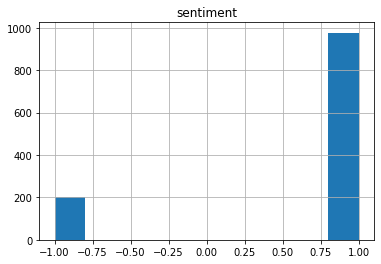

In [10]:
# View number of positive and negative sentiment
products.hist(column=['sentiment'])

Now, we can see that the dataset contains an extra column called **sentiment** which is either positive (+1) or negative (-1).

Note, there are significantly more positive reviews than negative reviews.

# Match number of positive and negative reviews

In [17]:
# Report number of positive examples
positive_sent = products[products['sentiment']==1]
print('There are {} positive reviews'.format(len(positive_sent)))

# Report number of negative examples
negative_sent = products[products['sentiment']==-1]
print('There are {} negative reviews'.format(len(negative_sent)))

# Sample number of negative example from positive examples using dr.sample()(# positive > # negative)
positive_sample = positive_sent.sample(n = len(negative_sent))
print('[Update] There are {} positive reviews'.format(len(positive_sample)))

# Merge positive and negative examples and update products dataframe
products = pd.concat([negative_sent, positive_sample])
print(products.head())

There are 200 positive reviews
There are 200 negative reviews
[Update] There are 200 positive reviews
                                              reviews  rating  \
17  The Kindle is my first e-ink reader. I own an ...     3.0   
18  The Kindle is my first e-ink reader. I own an ...     3.0   
36  Like a previous reviewer mentioned it is fabri...     3.0   
45  Updated 12/8/2014One year in...This review is ...     3.0   
47  After 15 months, my 500+ tablet is no longer u...     1.0   

                                                title  word_count_0  \
17  Worth the money. Not perfect, but very very go...           0.0   
18  Worth the money. Not perfect, but very very go...           0.0   
36                           Not all fabric or cloth.           0.0   
45  KF HDX 8.9 is ok do homework on Prime download...           0.0   
47                               Dead after 15 months           0.0   

    word_count_1  word_count_2  word_count_3  word_count_4  word_count_5  \
17  

## Split data into training and test sets

Let's perform a train/test split with 80% of the data in the training set and 20% of the data in the test set. We use `seed=1` so that everyone gets the same result.

In [19]:
from sklearn.model_selection import train_test_split

X = products.loc[:, ~products.columns.isin(['sentiment'])]

y = products.loc[:, products.columns.isin(['sentiment'])]


X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, 
                                                    random_state=1)
print(len(X_train))
print(len(y_train))

320
320


# Train a sentiment classifier with logistic regression

We will now use logistic regression to create a sentiment classifier on the training data. This model will use the column **word_count** as a feature and the column **sentiment** as the target. We will use `validation_set=None` to obtain same results as everyone else.

**Note:** This line may take 1-2 minutes.

In [21]:
X_train_sentiment = X_train.loc[:,X_train.columns.str.startswith('word_count_')]
X_test_sentiment = X_test.loc[:,X_test.columns.str.startswith('word_count_')]

X_train_sentiment.head()

,word_count_0,word_count_1,word_count_2,word_count_3,word_count_4,word_count_5,word_count_6,word_count_7,word_count_8,word_count_9,...,word_count_5626,word_count_5627,word_count_5628,word_count_5629,word_count_5630,word_count_5631,word_count_5632,word_count_5633,word_count_5634,word_count_5635
704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049397,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
from sklearn.linear_model import LogisticRegression
sentiment_model = LogisticRegression(random_state=0)
sentiment_model.fit(X_train_sentiment, np.ravel(y_train))

LogisticRegression(random_state=0)

**Aside**. You may get a warning to the effect of "Terminated due to numerical difficulties --- this model may not be ideal". It means that the quality metric (to be covered in Module 3) failed to improve in the last iteration of the run. The difficulty arises as the sentiment model puts too much weight on extremely rare words. A way to rectify this is to apply regularization, to be covered in Module 4. Regularization lessens the effect of extremely rare words. For the purpose of this assignment, however, please proceed with the model above.

Now that we have fitted the model, we can extract the weights (coefficients) as follows:

In [23]:
weights = sentiment_model.coef_
print(weights)

[[ 0.09156516 -0.00340068  0.         ...  0.         -0.04028037
   0.        ]]


There are a total of `6750` coefficients in the model. Recall from the lecture that positive weights $w_j$ correspond to weights that cause positive sentiment, while negative weights correspond to negative sentiment. 

Fill in the following block of code to calculate how many *weights* are positive ( >= 0). (**Hint**: Use numpy to sum the weights and check *weights* must be positive ( >= 0)).

In [24]:
num_positive_weights = np.sum(weights >= 0)
num_negative_weights = np.sum(weights < 0)

print("Number of positive weights: %s " % num_positive_weights)
print("Number of negative weights: %s " % num_negative_weights)

Number of positive weights: 3924 
Number of negative weights: 1712 


**Discussion Question:** How many weights are >= 0?

## Making predictions with logistic regression

Now that a model is trained, we can make predictions on the **test data**. In this section, we will explore this in the context of 3 examples in the test dataset.  We refer to this set of 3 examples as the **sample_test_data**.

In [25]:
sample_test_data = X_test[10:13]
print(sample_test_data['rating'])
sample_test_data

1142    3.0
1147    5.0
1163    1.0
Name: rating, dtype: float64


,reviews,rating,title,word_count_0,word_count_1,word_count_2,word_count_3,word_count_4,word_count_5,word_count_6,...,word_count_5626,word_count_5627,word_count_5628,word_count_5629,word_count_5630,word_count_5631,word_count_5632,word_count_5633,word_count_5634,word_count_5635
1142,While I've purchased items from Amazon for yea...,3.0,Awesome Headphones! Longevity An Issue 782 peo...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1147,"I bought these for a couple of reasons.First, ...",5.0,I hate having to shove headphones into my brai...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1163,"Remote didn't work, did all the troubleshootin...",1.0,Very disappointed.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's dig deeper into the first row of the **sample_test_data**. Here's the full review:

In [26]:
sample_test_data['reviews'].iloc[0]

"While I've purchased items from Amazon for years, I rarely write reviews. I felt compelled to write one because, although there are only a few reviews at this point, I have never seen such a good product get such bad reviews. I'm hoping as more people purchase these, the star rating will be more accurate of the product itself. I'll address the three biggest complaints I've read from others:Sound Quality: I think these headphones sound great. I've never owned an expensive pair so I'm not able to compare them to higher-end offerings, but I've owned dozens of cheap and mid-range headphones in the 15-50 range. I'm not an audiophile or a musician so if I'm missing something that should be coming through, but isn't, I'm fine with my ignorance. I would say they're slightly better than Apple's buds (which I liked very much and used for years, most recently using their redesigned ones for about a year). There's no tinny, listening through a can sound that's all-too-common with headphones in th

That review seems pretty positive.

Now, let's see what the next row of the **sample_test_data** looks like. As we could guess from the sentiment (-1), the review is quite negative.

In [18]:
sample_test_data['reviews'].iloc[1]

'I bought these for a couple of reasonsFirst I wanted an earbud that was NOT designed as noise cancelling I hate having to shove headphones into my brain to use them Apparently a lot of people are under the assumption that these are supposed to be noise cancelling or something which they are not They are simple earbuds I hate not being able to hear what is going on around me and dont feel safe in public using headphones that block everything else out These are designed just like the old style earbuds that you stick in your ears but they are more comfortable Maybe I have small ears or something but they could never fall out or dislodge from my ears They dont cancel the outside noise but they sit in my ears exactly as they are supposed to so the sound travels right into my earsSecond I really like the magnets and tangle free aspects of the headphones I use headphones while I work and the magnets allow me to hang the headphones easily when I am finished with them The flat cord and magnets

We will now make a **class** prediction for the **sample_test_data**. The `sentiment_model` should predict **+1** if the sentiment is positive and **-1** if the sentiment is negative. Recall from the lecture that the **score** (sometimes called **margin**) for the logistic regression model  is defined as:

$$
\mbox{score}_i = \mathbf{w}^T h(\mathbf{x}_i)
$$ 

where $h(\mathbf{x}_i)$ represents the features for example $i$.  We will write some code to obtain the **scores**. For each row, the **score** (or margin) is a number in the range **[-inf, inf]**.

In [28]:
scores = sample_test_data.loc[:, sample_test_data.columns.str.startswith('word_count_')].to_numpy() @ weights.reshape((-1)) + sentiment_model.intercept_
print(scores)

[-2.18135822  0.65041661 -0.67813938]


### Predicting sentiment

These scores can be used to make class predictions as follows:

$$
\hat{y} = 
\left\{
\begin{array}{ll}
      +1 & \mathbf{w}^T h(\mathbf{x}_i) > 0 \\
      -1 & \mathbf{w}^T h(\mathbf{x}_i) \leq 0 \\
\end{array} 
\right.
$$

Using scores, write code to calculate $\hat{y}$, the class predictions:

In [29]:
y_pred = np.where(scores > 0, 1, -1)
print(y_pred)

[-1  1 -1]


Run the following code to verify that the class predictions obtained by your calculations are the same as that obtained above.

In [30]:
print("Class predictions:")
print(sentiment_model.predict(
    sample_test_data.loc[:, sample_test_data.columns.str.startswith('word_count_')]))

Class predictions:
[-1  1 -1]


**Checkpoint**: Make sure your class predictions match with the one obtained from above.

### Probability predictions

Recall from the lectures that we can also calculate the probability predictions from the scores using:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))}.
$$

Using the variable **scores** calculated previously, write code to calculate the probability that a sentiment is positive using the above formula. For each row, the probabilities should be a number in the range **[0, 1]**.

In [22]:
# add code here

[0.60959701 0.60959701 0.5765648 ]


**Checkpoint**: Make sure your probability predictions match the ones obtained from sklearn.

In [23]:
# add code here

Class predictions for y=1:
[0.60959701 0.60959701 0.5765648 ]


** Discussion Question:** Of the three data points in **sample_test_data**, which one (first, second, or third) has the **lowest probability** of being classified as a positive review?

# Find the most positive (and negative) review

We now turn to examining the full test dataset, **test_data**, and use Numpy argsort to form predictions on all of the test data points for faster performance.

Using the `sentiment_model`, find the 20 reviews in the entire **test_data** with the **highest probability** of being classified as a **positive review**. We refer to these as the "most positive reviews."

To calculate these top-20 reviews, use the following steps:
1.  Make probability predictions on **test_data** using the `sentiment_model`. (**Hint:** When you call `.predict` to make predictions on the test data.)
2.  Sort the data according to those predictions and pick the top 20. (**Hint:** You can use indexing [-topn:] to find the top k rows sorted according to the value of a specified column.)

In [24]:
# Calculate the class probabilities for the test set
y_prob = sentiment_model.predict_proba(X_test_sentiment)

# Sort the test set in descending order of their probabilities of being positive
idx = np.argsort(-y_prob[:, 1])

# Get the indices of the 20 most positive reviews
idx_most_positive = idx[-20:] 
print(idx_most_positive)

# Get the corresponding reviews from the test set
most_positive_reviews = X_test.iloc[idx_most_positive]
print(most_positive_reviews)

[20 18 27  6 17 13 23  8  9 25 26  4 16 22 14  7 30 28  2  0]
                                                reviews  rating  \
342        Works great to protect the Kindle from drops     5.0   
738   The Ultimate Bluetooth speakerI have multiple ...     5.0   
842   I was not overly impressed with this system I ...     2.0   
62    Im a huge fan of the Echo family I have two Ec...     5.0   
371   Really awesome tablet for my 5 year olds and w...     4.0   
677   I have been enjoying the amazon tap for two we...     5.0   
833   I really havent had a chance to use this much ...     4.0   
968   As good as the Echo is the Echo Voice Remote s...     2.0   
876   Could not get it to work properly I put the ap...     1.0   
776   hard to use and does not support Guam online i...     1.0   
267   In this day and age of rectangles with screens...     2.0   
469   Just really thought it would have been more us...     2.0   
217                                                 Too     2.0   


**Discussion Question**: Which of the following products are represented in the 20 most positive reviews? [multiple choice]


Now, let us repeat this exercise to find the "most negative reviews." Use the prediction probabilities to find the  20 reviews in the **test_data** with the **lowest probability** of being classified as a **positive review**. Repeat the same steps above but make sure you **sort in the opposite order**.

In [25]:
# Get the indices of the 20 most negative reviews
idx_most_negative = idx[:20]

# Get the corresponding reviews from the test set
most_negative_reviews = X_test.iloc[idx_most_negative]
print(most_negative_reviews)

                                                reviews  rating  \
678   We have had the fullsize Echo for over a year ...     5.0   
1026  I bought these for a couple of reasonsFirst I ...     5.0   
1013  I bought these for a couple of reasonsFirst I ...     5.0   
1001  I bought these for a couple of reasonsFirst I ...     5.0   
819   I love using this as a speaker for my MacBook ...     5.0   
172   I am not a casual user of ondemand content and...     5.0   
796   We have the tap and the echo I wouldnt buy ano...     4.0   
837   As a bluetooth speaker the Tap rocks The sound...     5.0   
507   Love having someone to take notes for me and p...     4.0   
512   Love the Dot Hate the Tap Portable This device...     2.0   
460   Great product for intro to an AI device Cant w...     5.0   
342        Works great to protect the Kindle from drops     5.0   
738   The Ultimate Bluetooth speakerI have multiple ...     5.0   
842   I was not overly impressed with this system I ...     2.

**Question**: Which of the following products are represented in the 20 most negative reviews?

## Compute accuracy of the classifier

We will now evaluate the accuracy of the trained classifier. Recall that the accuracy is given by


$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

This can be computed as follows:

* **Step 1:** Use the trained model to compute class predictions (**Hint:** Use the `predict` method)
* **Step 2:** Count the number of data points when the predicted class labels match the ground truth labels (called `true_labels` below).
* **Step 3:** Divide the total number of correct predictions by the total number of data points in the dataset.

Complete the function below to compute the classification accuracy:

In [26]:
def get_classification_accuracy(model, data, true_labels):
    # First get the predictions
    ## add code here
    
    # Compute the number of correctly classified examples
    ## add code here

    # Then compute accuracy by dividing num_correct by total number of examples
    ## add code here
    
    return accuracy

Now, let's compute the classification accuracy of the **sentiment_model** on the **test_data**.

In [27]:
#add code here

0.8709677419354839

**Discussion Question**: What is the accuracy of the **sentiment_model** on the **test_data**? Round your answer to 2 decimal places (e.g. 0.76).

**Discussion Question**: Does a higher accuracy value on the **training_data** always imply that the classifier is better?

## Learn another classifier with fewer words

There were a lot of words in the model we trained above. We will now train a simpler logistic regression model using only a subset of words that occur in the reviews. For this assignment, we selected a 20 words to work with. These are:

In [28]:
significant_words = ['love', 'great', 'easy', 'old', 'amazing', 'perfect', 'loves', 
      'well', 'able', 'car', 'broke', 'less', 'even', 'waste', 'disappointed', 
      'work', 'product', 'money', 'would', 'return']

In [29]:
len(significant_words)

20

In [30]:
#all_words = count_vect.get_feature_names_out() # newer version of sklearn
all_words = count_vect.get_feature_names()

For each review, we will use the **word_count** column and trim out all words that are **not** in the **significant_words** list above. We will use the [SArray dictionary trim by keys functionality]( https://dato.com/products/create/docs/generated/graphlab.SArray.dict_trim_by_keys.html). Note that we are performing this on both the training and test set.

In [31]:
# Extract significant words and split train/test sets

sig_word_set = set(significant_words)
sig_idx = [i for i, e in enumerate(all_words) if e in sig_word_set]

X_train_sig = X_train_sentiment.iloc[:, sig_idx]
X_test_sig = X_test_sentiment.iloc[:, sig_idx]

X_train_sig.head()

,word_count_310,word_count_515,word_count_1016,word_count_1137,word_count_1838,word_count_2039,word_count_2192,word_count_2764,word_count_3522,word_count_3662,word_count_3666,word_count_3901,word_count_4164,word_count_4416,word_count_4680,word_count_5069,word_count_6489,word_count_6538,word_count_6648,word_count_6671
229,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.108244,0.000000,0.0,0.0,0.0,0.155978,0.000000,0.000000,0.000000
1020,0.032729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.039824,0.0,0.0,0.0,0.000000,0.000000,0.031833,0.025422
170,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
781,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.221342,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.114759
211,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.109139,0.000000,0.000000


Let's see what the first example of the dataset looks like:

In [32]:
X_train['reviews'].iloc[0]

'I typically dont post reviews however dont waste your money on this case I got it on Friday and started using it that evening Its now Thursday and the case is peeling at the edges the fabric around the camera hole has started bubbling and the felt on the inside edge is wearing off i have not had any issues with it standing on its own like other people have mentioned I am giving this a two star mainly because it is still functional I am tempted to send it back but I like the functionality of this case'

The **word_count** column had been working with before looks like the following:

In [33]:
X_train_sentiment.iloc[0, :]

word_count_0       0.0
word_count_1       0.0
word_count_2       0.0
word_count_3       0.0
word_count_4       0.0
                  ... 
word_count_6745    0.0
word_count_6746    0.0
word_count_6747    0.0
word_count_6748    0.0
word_count_6749    0.0
Name: 229, Length: 6750, dtype: float64

Since we are only working with a subset of these words, the column **word_count_subset** is a subset of the above dictionary. In this example, only 2 `significant words` are present in this review.

In [34]:
X_train_sig.iloc[0, :]

word_count_310     0.000000
word_count_515     0.000000
word_count_1016    0.000000
word_count_1137    0.000000
word_count_1838    0.000000
word_count_2039    0.000000
word_count_2192    0.000000
word_count_2764    0.000000
word_count_3522    0.000000
word_count_3662    0.000000
word_count_3666    0.000000
word_count_3901    0.108244
word_count_4164    0.000000
word_count_4416    0.000000
word_count_4680    0.000000
word_count_5069    0.000000
word_count_6489    0.155978
word_count_6538    0.000000
word_count_6648    0.000000
word_count_6671    0.000000
Name: 229, dtype: float64

## Train a logistic regression model on a subset of data

We will now build a classifier with **word_count_subset** with significant words as the feature and **sentiment** as the target. 

In [35]:
# add code here

LogisticRegression(random_state=0)


We can compute the classification accuracy using the `get_classification_accuracy` function you implemented earlier.

In [36]:
# add code here

0.5483870967741935

Now, we will inspect the weights (coefficients) of the **simple_model**:

In [37]:
print(simple_model.coef_)

[[ 0.07104329  0.03778847  0.         -0.06656962 -0.19825001  0.47819648
  -0.15147854  0.93499694  0.04017237  1.0106324   0.11614478 -0.1889335
   0.05475834  0.54754391  0.04338208 -0.09360217 -0.42243534  0.15243118
  -0.19370058 -0.1932077 ]]


Let's sort the coefficients (in descending order) by the **value** to obtain the coefficients with the most positive effect on the sentiment.

In [38]:
print(-np.sort(-simple_model.coef_, ))

[[ 1.0106324   0.93499694  0.54754391  0.47819648  0.15243118  0.11614478
   0.07104329  0.05475834  0.04338208  0.04017237  0.03778847  0.
  -0.06656962 -0.09360217 -0.15147854 -0.1889335  -0.1932077  -0.19370058
  -0.19825001 -0.42243534]]


**Discussion Question**: Consider the coefficients of **simple_model**. There should be 21 of them, an intercept term + one for each word in **significant_words**. How many of the 20 coefficients (corresponding to the 20 **significant_words** and *excluding the intercept term*) are positive for the `simple_model`?

In [39]:
num_positive_weights = np.sum(simple_model.coef_ >= 0)
print(num_positive_weights)

12


**Discussion Question**: Are the positive words in the **simple_model** (let us call them `positive_significant_words`) also positive words in the **sentiment_model**?

# Comparing models

We will now compare the accuracy of the **sentiment_model** and the **simple_model** using the `get_classification_accuracy` method you implemented above.

First, compute the classification accuracy of the **sentiment_model** on the **train_data**:

In [40]:
# add code here

0.9834710743801653


Now, compute the classification accuracy of the **simple_model** on the **train_data**:

In [41]:
# add code here

0.6363636363636364


**Discussion Question**: Which model (**sentiment_model** or **simple_model**) has higher accuracy on the TRAINING set?

Now, we will repeat this exercise on the **test_data**. Start by computing the classification accuracy of the **sentiment_model** on the **test_data**:

In [42]:
# add code here

0.8709677419354839


Next, we will compute the classification accuracy of the **simple_model** on the **test_data**:

In [43]:
# add code here

0.5483870967741935

**Discussion Question**: Which model (**sentiment_model** or **simple_model**) has higher accuracy on the TEST set?

**Discussion Question**: Comment out the sention on 'Match number of positive and negative reviews' and re-run the notebook. Which model (**sentiment_model** or **simple_model**) has higher accuracy on the TEST set? 

## Baseline: Majority class prediction

It is quite common to use the **majority class classifier** as the a baseline (or reference) model for comparison with your classifier model. The majority classifier model predicts the majority class for all data points. At the very least, you should healthily beat the majority class classifier, otherwise, the model is (usually) pointless.

What is the majority class in the **train_data**?

In [44]:
# add code here

59
62


Now compute the accuracy of the majority class classifier on **test_data**.

**Discussion Question**: Enter the accuracy of the majority class classifier model on the **test_data**. Round your answer to two decimal places (e.g. 0.76).

In [45]:
# add code here

sentiment    0.451613
dtype: float64


**Discussion Question**: Is the **sentiment_model** definitely better than the majority class classifier (the baseline)?